In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
from matplotlib import pyplot as plt
from sklearn import metrics

Na tych zajęciach należy zaimplementować sieć neuronową typu MLP, w której można ustawić: liczbę warstw, liczbę neuronów w każdej z warstw i wagi poszczególnych połączeń, w tym biasów. Sieć ma używać sigmoidalnej funkcji aktywacji. Na wyjściu dopuszczana jest funkcja liniowa.

Implementacja sieci musi być przygotowana w taki sposób, żeby łatwo zmieniać:
- Architekturę, to znaczy liczbę wejść, wyjść, neuronów w warstwach ukrytych.
- Funkcję aktywacji.

Tak przygotowaną implementację należy następnie wykorzystać do rozwiązania zadania regresji na dostarczonych danych. Parametry sieci należy dobrać ręcznie, tak aby uzyskać możliwie dobrze wyniki na zbiorach danych (zbudować po jednej sieci dla każdego zbioru):
- square-simple
- steps-large

Rozważyć architektury sieci:
- jedna warstwa ukryta, 5 neuronów,
- jedna warstwa ukryta, 10 neuronów,
- dwie warstwy ukryte, po 5 neuronów każda.

In [12]:
from abc import ABC, abstractmethod
import logging

class Neuron(ABC):
    @abstractmethod
    def evaluate(self, input: list) -> float:
        pass
    
    def dot(a: list, b: list) -> float:
        tmp = min(len(a), len(b))
        return np.dot(a[:tmp], b[:tmp])

    
# pierwsza waga to waga biasu
class LinearNeuron(Neuron):
    def __init__(self, weights: list) -> None:
        self.weights = weights
        if len(weights) < 2:
            logging.warning("Less than 2 weights. Are you sure?")
            
    def evaluate(self, input: list) -> float:
        return Neuron.dot(self.weights, [1] + input)
        

class SigmoidNeuron(Neuron):
    def __init__(self, weights: list) -> None:
        self.weights = weights
        if len(weights) < 2:
            logging.warning("Less than 2 weights. Are you sure?")
            
    def evaluate(self, input: list) -> float:
        x = Neuron.dot(self.weights, [1] + input)
        return math.e ** x / (1 + math.e ** x)

# tests

assert Neuron.dot([2,3], [5]) == 10
assert Neuron.dot([2,3], [4,5,6]) == 23

linearneuron = LinearNeuron([1,2,3])
assert linearneuron.evaluate([1,2,3]) == 9
assert linearneuron.evaluate([2,3]) == 14

sigmoidneuron = SigmoidNeuron([1, 2])
assert sigmoidneuron.evaluate([1]) == math.e ** 3 / (1 + math.e ** 3)

In [4]:
class Layer(ABC):
    def __init__(self) -> None:
        self.neurons = []
    
    @abstractmethod
    def __init__(self, num: int, weights: list) -> None:
        pass
        
    def addNeuron(self, neuron: Neuron) -> None:
        self.neurons.append(neuron)
        
    def evaluate(self, input: list) -> list:
        return [neuron.evaluate(input) for neuron in self.neurons]
    

class LinearLayer(Layer):
    def __init__(self, num: int, weights: list) -> None:
        assert len(weights) == num, "Invalid matrix dimension"
        self.neurons = [LinearNeuron(w) for w in weights]
    
class SigmoidLayer(Layer):
    def __init__(self, num: int, weights: list) -> None:
        assert len(weights) == num, "Invalid matrix dimension"
        self.neurons = [SigmoidNeuron(w) for w in weights]

# tests
layer1 = LinearLayer(1, [[1, 2]])
assert layer1.evaluate([5]) == [11]
layer1.addNeuron(LinearNeuron([2, 3]))
assert layer1.evaluate([5]) == [11, 17]

layer2 = LinearLayer(2, [[1,2], [2, 3]])
assert layer2.evaluate([5]) == [11, 17]

In [18]:
class Network:
    def __init__(self) -> None:
        self.layers = []
    
    def __init__(self, layer_types: list, weights: list) -> None:
        assert len(layer_types) == len(weights), "Invalid matrix dimension"
        self.layers = []
        for i in range(len(weights)):
            if layer_types[i] == "sigmoid":
                self.addLayerBack(SigmoidLayer(len(weights[i]), weights[i]))
            elif layer_types[i] == "linear":
                self.addLayerBack(LinearLayer(len(weights[i]), weights[i]))
            else:
                logging.error("Invalid layer type")
        
    def addLayerBack(self, layer: Layer) -> None:
        self.layers.append(layer)
    
    def forward(self, x: list) -> list:
        input = x
        for layer in self.layers:
            out = []
            for val in input:
                out.append(layer.evaluate(val))
            input = out
        return input

In [6]:
train_df = pd.read_csv('./mio1/regression/square-simple-training.csv', index_col=0)
test_df = pd.read_csv('./mio1/regression/square-simple-test.csv', index_col=0)
train_df

,x,y
1,-0.171543,-127.351580
2,0.025201,-129.942844
3,-1.368991,38.672367
4,1.907390,197.432191
5,0.011129,-129.988852
...,...,...
96,0.529373,-104.778766
97,1.374914,40.134900
98,-1.101985,-20.706642
99,1.175777,-5.579327


In [7]:
train_df['split'] = 'train'
test_df['split'] = 'test'
df = pd.concat([train_df, test_df])

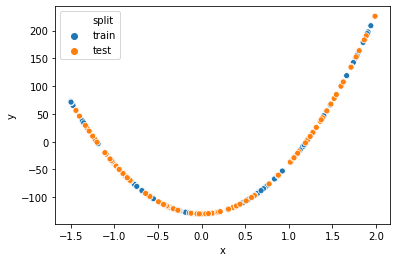

In [9]:
sns.scatterplot(x='x', y='y', hue='split', data=df)

In [11]:
train_df = df.query('split == "train"')
x = train_df['x'].values
x = np.expand_dims(x, 1)

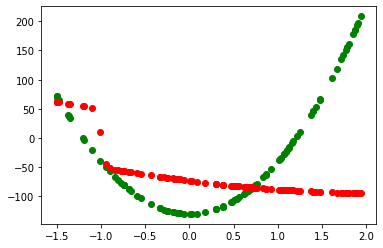

In [105]:
mlp = Network(["sigmoid", "linear"], [
    [
        [1, -5],
        [1, 1],
        [1, 1],
        [1, 3],
        [-50, 2]
    ],
    [
        [0,-100,0,0,0,100]
    ]])
y_pred = mlp.forward(x)
y_pred = np.squeeze(y_pred)
plt.scatter(train_df['x'], train_df['y'], color='green')
plt.scatter(train_df['x'], y_pred, color='red')

In [106]:
metrics.mean_absolute_error(train_df['y'], y_pred)

72.74840770322075